# CAPTCHA Recognition using CRNN and CTC Loss

# ETL (Extract, Transform, Load)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import editdistance
import pandas as pd
import json
import time

In [3]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Constants
RAW_FOLDER = "/kaggle/input/captcha-dataset"
TIME_STEPS = 9
BATCH_SIZE = 64
EPOCHS = 50
IMG_HEIGHT = 24
IMG_WIDTH = 72
PATIENCE = 15
MIN_DELTA = 1e-4
VIS_EVERY = 5
MAX_IMAGES = 80000  # Use up to 80,000 images
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_FILE = os.path.join(CHECKPOINT_DIR, "checkpoint.pth")
METRICS_FILE = os.path.join(CHECKPOINT_DIR, "metrics.json")

Using device: cuda


# ETL

Number of files extracted: 80000
Total number of characters: 60
Characters: 123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnpqrstuvwxyz


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


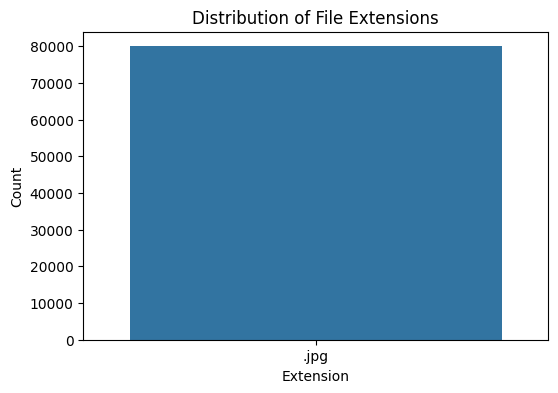

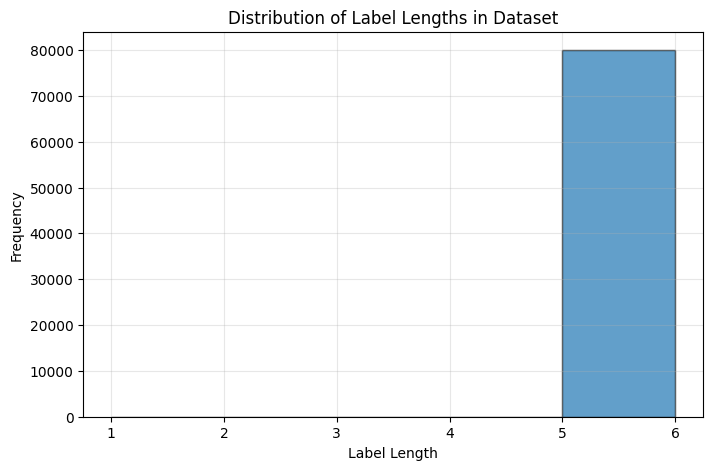

In [4]:
# Create checkpoint directory if it doesn't exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Extract: Load file names and labels
dict_file_label = {}
char_list = set()
num_files = 0
label_lengths = []
file_extensions = []
all_image_paths = []
for filename in os.listdir(RAW_FOLDER)[:MAX_IMAGES]:  # Limit to 80,000 images
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        label = os.path.splitext(filename)[0]
        image_path = os.path.join(RAW_FOLDER, filename)
        dict_file_label[image_path] = label
        char_list.update(label)
        label_lengths.append(len(label))
        file_extensions.append(os.path.splitext(filename)[1])
        all_image_paths.append(image_path)
        num_files += 1
print(f"Number of files extracted: {num_files}")

# Transform: Build char list
char_list = sorted(list(char_list))
print(f"Total number of characters: {len(char_list)}")
print("Characters:", ''.join(char_list))
NUM_CLASSES = len(char_list)
BLANK_IDX = NUM_CLASSES

# Visualization: File extensions distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=file_extensions)
plt.title('Distribution of File Extensions')
plt.xlabel('Extension')
plt.ylabel('Count')
plt.show()

# Visualization: Histogram of label lengths
plt.figure(figsize=(8, 5))
plt.hist(label_lengths, bins=range(1, max(label_lengths)+2), alpha=0.7, edgecolor='black')
plt.title('Distribution of Label Lengths in Dataset')
plt.xlabel('Label Length')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# PREPROCESSING

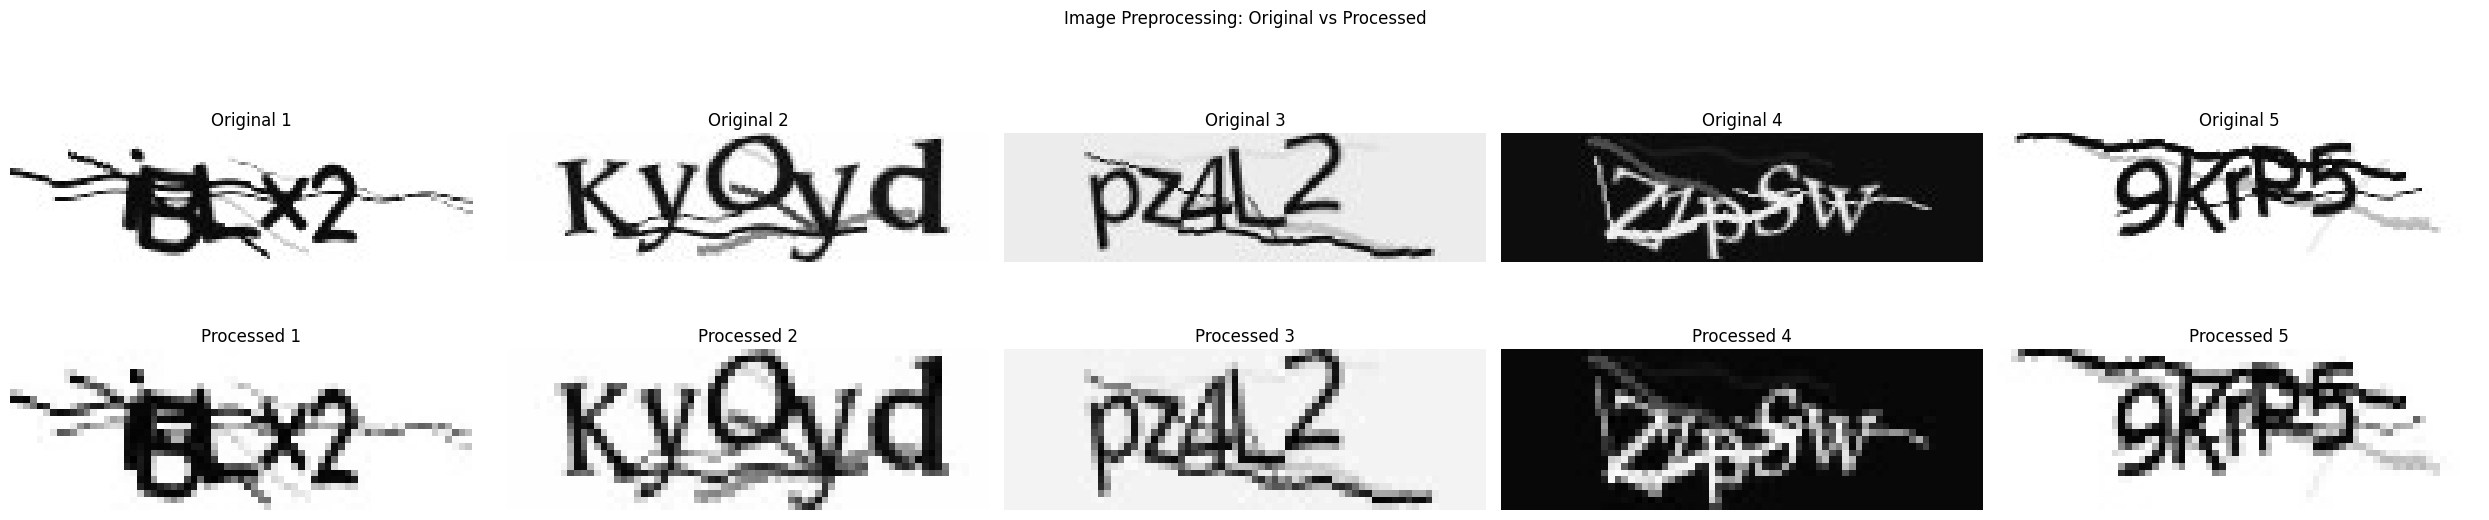

In [5]:
def encode_to_labels(txt, char_list):
    return [char_list.index(char) for char in txt]

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_img = img.copy()
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = img.astype(np.float32) / 255.0
    return original_img, img

# Visualization: Before and after preprocessing for samples
num_preproc_samples = min(5, len(all_image_paths))
fig, axs = plt.subplots(2, num_preproc_samples, figsize=(5*num_preproc_samples, 6))
for i in range(num_preproc_samples):
    original, processed = preprocess_image(all_image_paths[i])
    axs[0, i].imshow(original, cmap='gray')
    axs[0, i].set_title(f'Original {i+1}')
    axs[0, i].axis('off')
    axs[1, i].imshow(processed, cmap='gray')
    axs[1, i].set_title(f'Processed {i+1}')
    axs[1, i].axis('off')
plt.suptitle('Image Preprocessing: Original vs Processed')
plt.tight_layout()
plt.show()

# DIVIDING THE DATASET INTO TRAIN, VAL, TEST

Train size: 56000, Val size: 12000, Test size: 12000


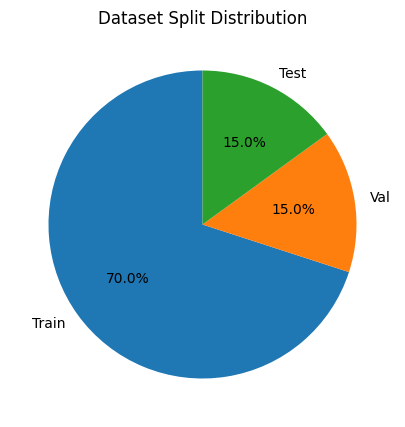

In [6]:
train_paths, temp_paths = train_test_split(all_image_paths, test_size=0.3, random_state=42)
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)
train_labels = [dict_file_label[path] for path in train_paths]
val_labels = [dict_file_label[path] for path in val_paths]
test_labels = [dict_file_label[path] for path in test_paths]
print(f"Train size: {len(train_paths)}, Val size: {len(val_paths)}, Test size: {len(test_paths)}")

# Visualization: Size distribution
sizes = [len(train_paths), len(val_paths), len(test_paths)]
labels = ['Train', 'Val', 'Test']
plt.figure(figsize=(8, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split Distribution')
plt.show()

# DATASET AND DATALOADER

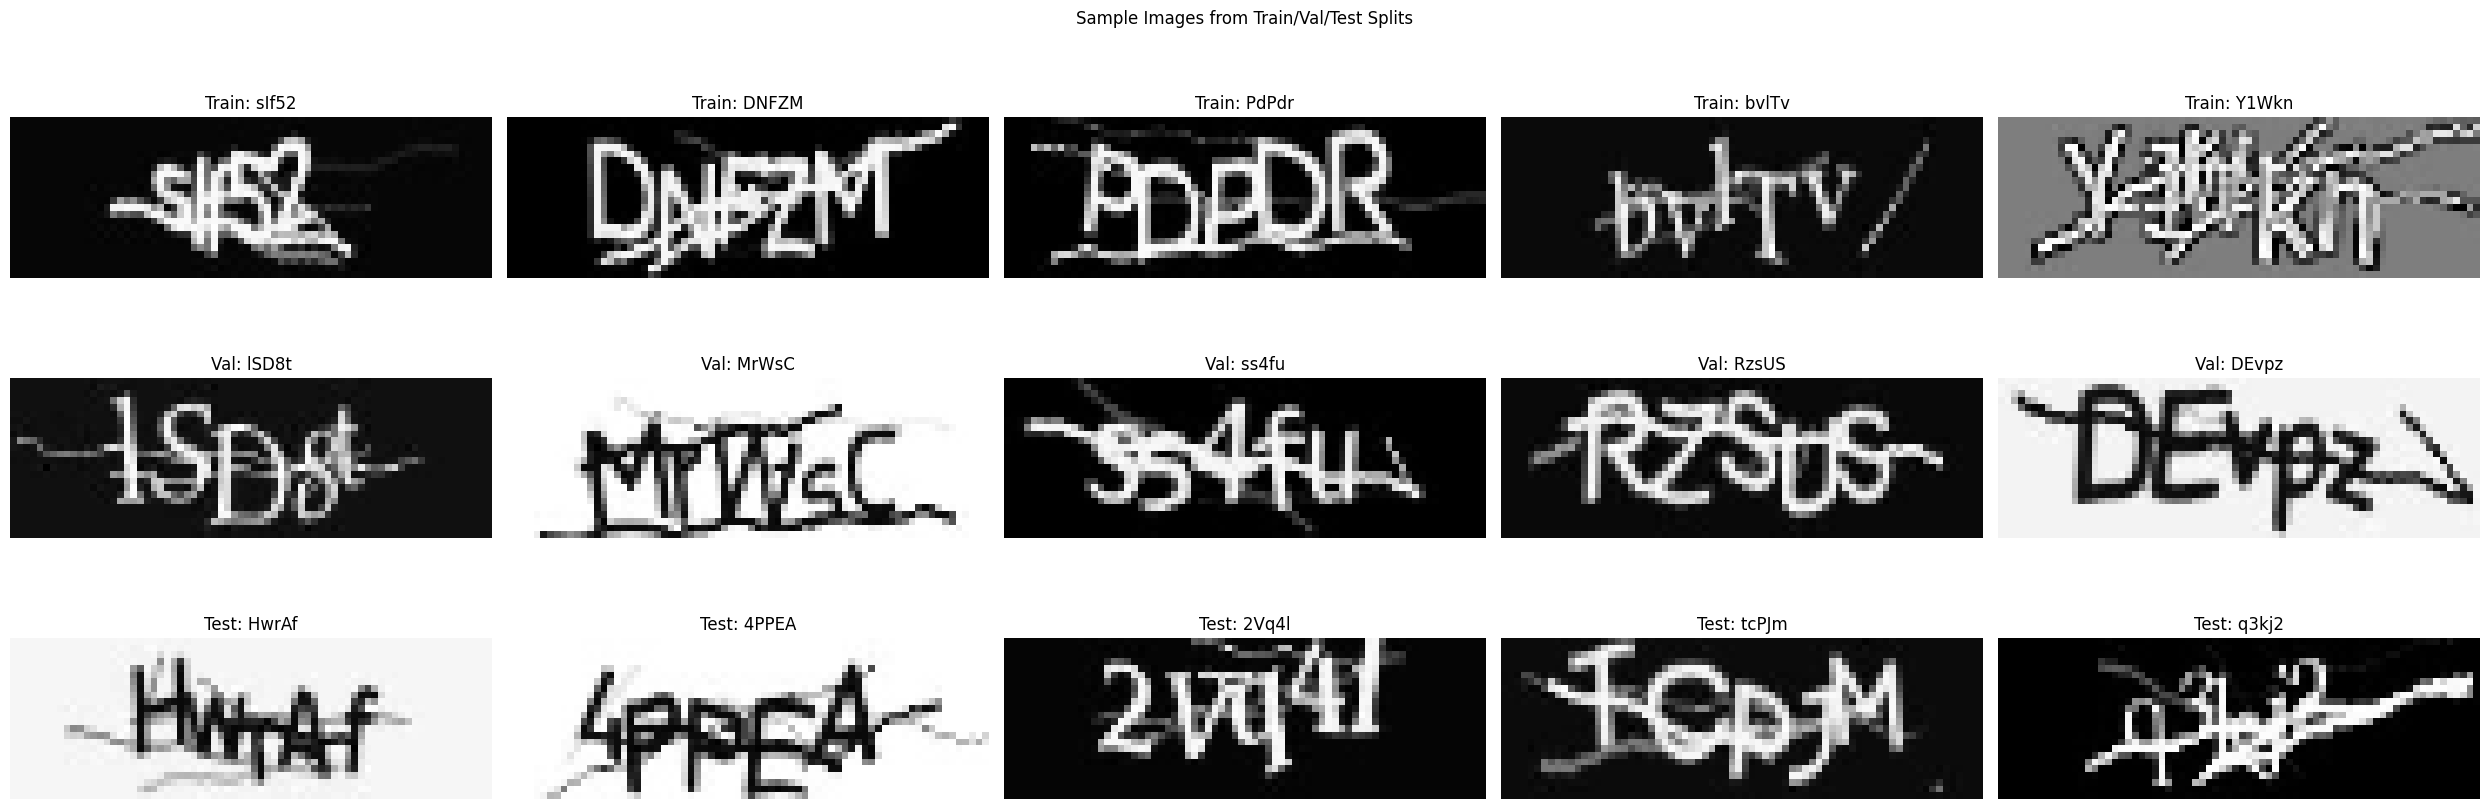

In [7]:
class CaptchaDataset(Dataset):
    def __init__(self, image_paths, labels, char_list, split='train'):
        self.image_paths = image_paths
        self.labels_str = labels
        self.labels_idx = [encode_to_labels(label, char_list) for label in labels]
        self.split = split
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_str = self.labels_str[idx]
        label_idx = self.labels_idx[idx]
        _, img = preprocess_image(img_path)
        img = torch.from_numpy(img).unsqueeze(0)
        label = torch.tensor(label_idx, dtype=torch.int32)
        return img, label, label_str

def collate_fn(batch):
    imgs, labels, label_strs = zip(*batch)
    imgs = torch.stack(imgs, 0)
    targets = torch.cat(labels, dim=0)
    target_lengths = torch.tensor([len(l) for l in labels], dtype=torch.int32)
    input_lengths = torch.full((len(batch),), TIME_STEPS, dtype=torch.int32)
    return imgs, targets, input_lengths, target_lengths, list(label_strs)

train_dataset = CaptchaDataset(train_paths, train_labels, char_list, split='train')
val_dataset = CaptchaDataset(val_paths, val_labels, char_list, split='val')
test_dataset = CaptchaDataset(test_paths, test_labels, char_list, split='test')
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Visualization: Sample from each split
splits = [('Train', train_loader), ('Val', val_loader), ('Test', test_loader)]
num_split_samples = min(5, BATCH_SIZE)
fig, axs = plt.subplots(3, num_split_samples, figsize=(5*num_split_samples, 9))
idx = 0
for split_name, loader in splits:
    for batch in loader:
        imgs, _, _, _, label_strs = batch
        for j in range(num_split_samples):
            axs[idx, j].imshow(imgs[j].squeeze(0), cmap='gray')
            axs[idx, j].set_title(f'{split_name}: {label_strs[j]}')
            axs[idx, j].axis('off')
        idx += 1
        break
plt.suptitle('Sample Images from Train/Val/Test Splits')
plt.tight_layout()
plt.show()

# MODEL BUILDING

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


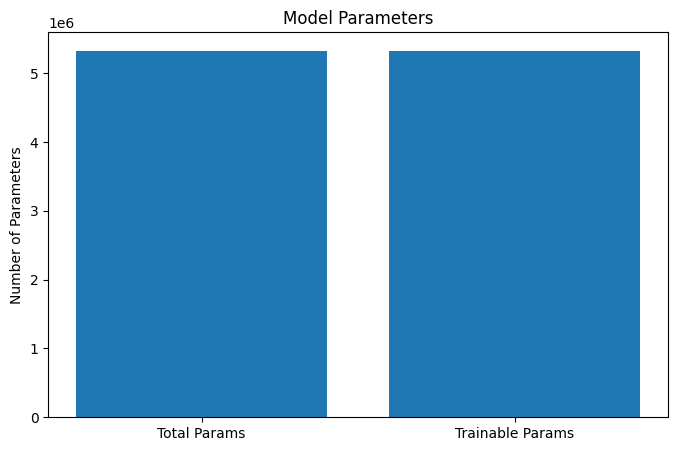

Total model parameters: 5,327,549


In [8]:
class CRNN(nn.Module):
    def __init__(self, num_classes, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
        super(CRNN, self).__init__()
        self.num_classes = num_classes + 1
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(3, 1), stride=(3, 1))
        )
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=False, dropout=0.3)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=False, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, self.num_classes)
    def forward(self, x):
        conv = self.cnn(x).squeeze(2)
        conv = conv.permute(2, 0, 1)
        lstm_out, _ = self.lstm1(conv)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        return out

model = CRNN(NUM_CLASSES).to(device)

# Visualization: Model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
plt.figure(figsize=(8, 5))
plt.bar(['Total Params', 'Trainable Params'], [total_params, trainable_params])
plt.title('Model Parameters')
plt.ylabel('Number of Parameters')
plt.show()
print(f"Total model parameters: {total_params:,}")

# TRAINING SETUP

Initial Train Acc: 0.03571203939895762
Initial Val Acc: 0.024498379629634193


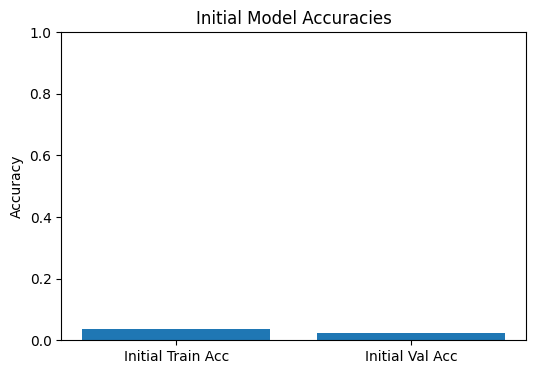

In [9]:
criterion = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

# Load checkpoint if it exists
start_epoch = 0
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_val_loss = float('inf')
if os.path.exists(CHECKPOINT_FILE):
    checkpoint = torch.load(CHECKPOINT_FILE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    train_accs = checkpoint['train_accs']
    val_accs = checkpoint['val_accs']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Resuming training from epoch {start_epoch}")

def ctc_greedy_decode(log_probs, blank_idx):
    T, N, C = log_probs.shape
    predictions = []
    for i in range(N):
        pred = torch.argmax(log_probs[:, i, :], dim=1)
        decoded = []
        prev = blank_idx
        for t in range(T):
            p = pred[t].item()
            if p != blank_idx and p != prev:
                decoded.append(p)
            prev = p
        predictions.append(torch.tensor(decoded, dtype=torch.int32))
    return predictions

def compute_ser(model, loader, device, is_train=False):
    model.eval() if not is_train else model.train()
    total_ser = 0
    total_samples = 0
    with torch.no_grad() if not is_train else torch.enable_grad():
        for imgs, _, input_lens, target_lens, label_strs in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            log_probs = F.log_softmax(outputs, dim=2)
            predictions = ctc_greedy_decode(log_probs, BLANK_IDX)
            for j in range(len(imgs)):
                pred_list = predictions[j].cpu().numpy()
                pred_str = ''.join([char_list[idx] for idx in pred_list if idx < len(char_list)])
                orig_str = label_strs[j]
                dist = editdistance.eval(list(pred_str), list(orig_str))
                ser = dist / max(len(pred_str), len(orig_str)) if max(len(pred_str), len(orig_str)) > 0 else 0
                total_ser += ser
                total_samples += 1
    avg_ser = total_ser / total_samples if total_samples > 0 else 0
    return 1 - avg_ser

initial_train_acc = compute_ser(model, train_loader, device, is_train=True)
initial_val_acc = compute_ser(model, val_loader, device)
print("Initial Train Acc:", initial_train_acc)
print("Initial Val Acc:", initial_val_acc)
plt.figure(figsize=(6, 4))
plt.bar(['Initial Train Acc', 'Initial Val Acc'], [initial_train_acc, initial_val_acc])
plt.title('Initial Model Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# TRAINING

Epoch 1/50 - Train Loss: 1.9107, Val Loss: 1.1678, Train Acc: 0.6978, Val Acc: 0.6809, LR: 0.000500
Saved best model at epoch 1
Epoch 2/50 - Train Loss: 1.0486, Val Loss: 0.9429, Train Acc: 0.7622, Val Acc: 0.7284, LR: 0.000500
Saved best model at epoch 2
Epoch 3/50 - Train Loss: 0.8295, Val Loss: 0.8130, Train Acc: 0.8046, Val Acc: 0.7613, LR: 0.000500
Saved best model at epoch 3
Epoch 4/50 - Train Loss: 0.7031, Val Loss: 0.7764, Train Acc: 0.8171, Val Acc: 0.7663, LR: 0.000500
Saved best model at epoch 4
Epoch 5/50 - Train Loss: 0.6304, Val Loss: 0.7454, Train Acc: 0.8341, Val Acc: 0.7757, LR: 0.000500
Saved best model at epoch 5


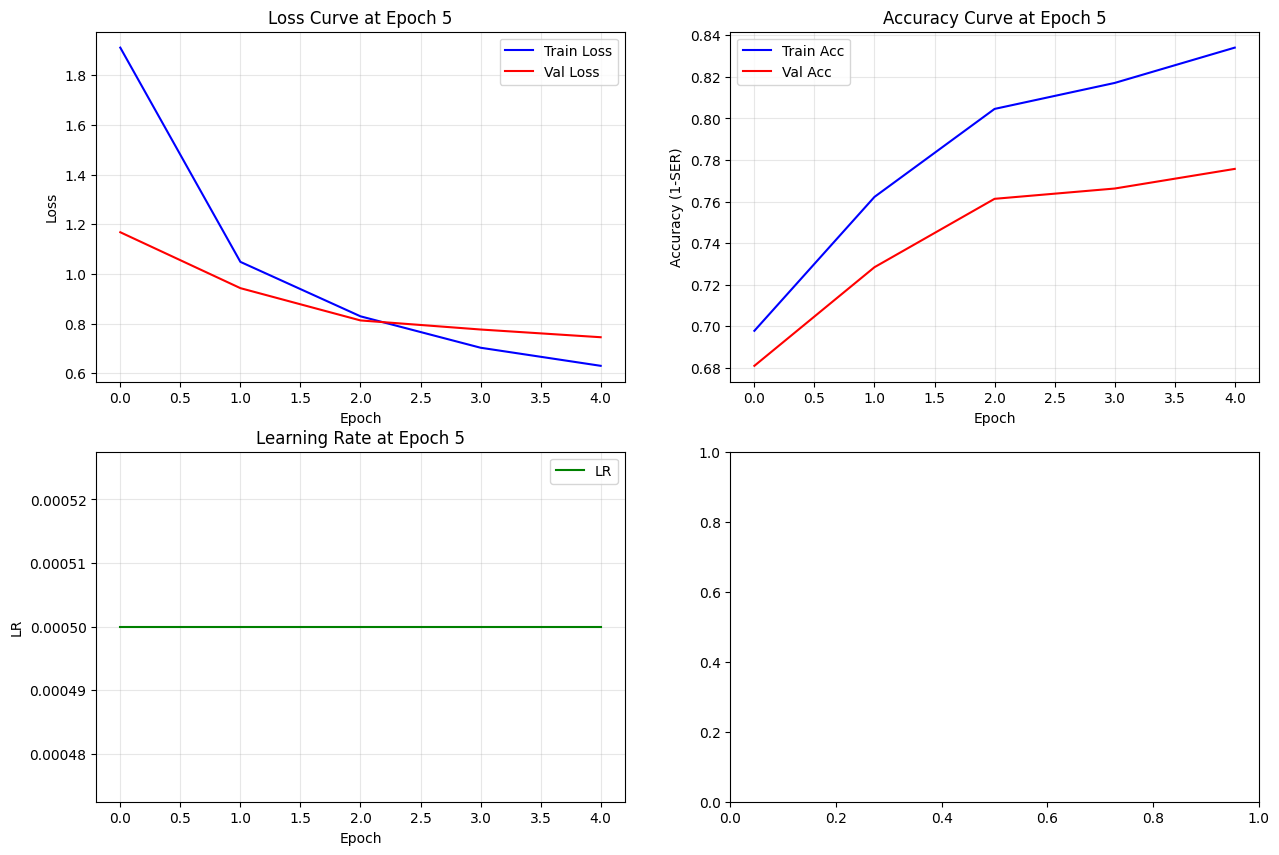

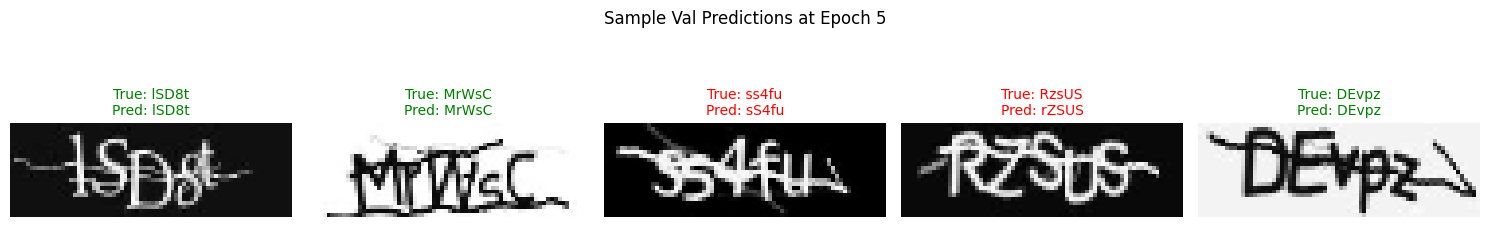

<Figure size 640x480 with 0 Axes>

Epoch 6/50 - Train Loss: 0.5739, Val Loss: 0.7287, Train Acc: 0.8450, Val Acc: 0.7789, LR: 0.000500
Saved best model at epoch 6
Epoch 7/50 - Train Loss: 0.5342, Val Loss: 0.7247, Train Acc: 0.8526, Val Acc: 0.7842, LR: 0.000500
Saved best model at epoch 7
Epoch 8/50 - Train Loss: 0.5064, Val Loss: 0.7005, Train Acc: 0.8622, Val Acc: 0.7889, LR: 0.000500
Saved best model at epoch 8
Epoch 9/50 - Train Loss: 0.4834, Val Loss: 0.6904, Train Acc: 0.8690, Val Acc: 0.7951, LR: 0.000500
Saved best model at epoch 9
Epoch 10/50 - Train Loss: 0.4666, Val Loss: 0.7043, Train Acc: 0.8653, Val Acc: 0.7870, LR: 0.000500


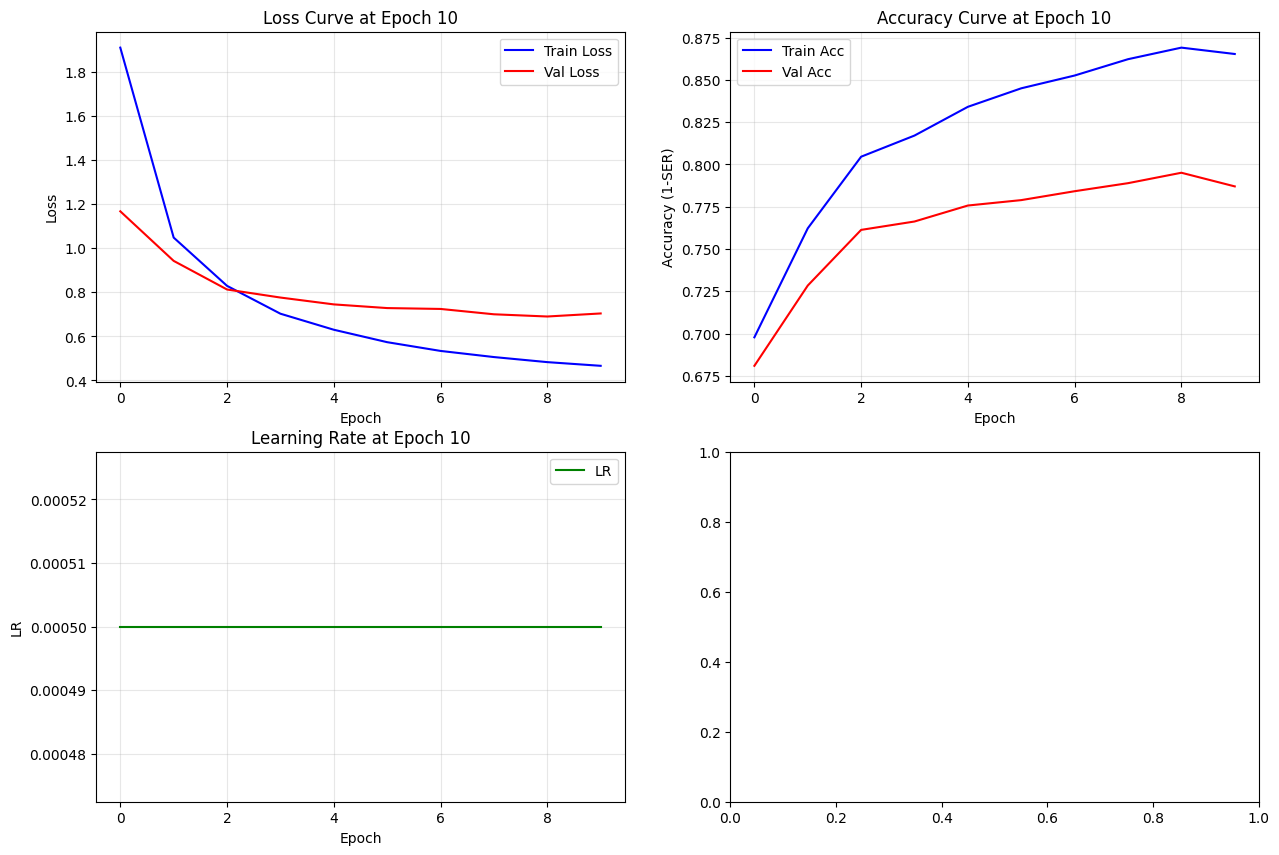

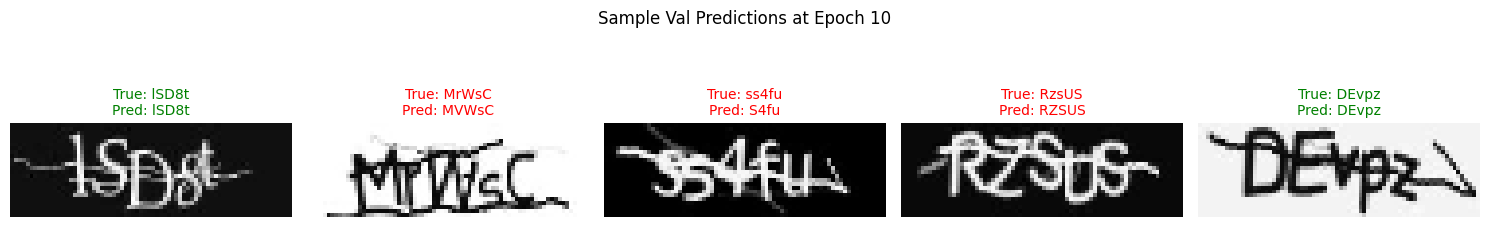

<Figure size 640x480 with 0 Axes>

Epoch 11/50 - Train Loss: 0.4521, Val Loss: 0.6973, Train Acc: 0.8744, Val Acc: 0.7940, LR: 0.000500
Epoch 12/50 - Train Loss: 0.4394, Val Loss: 0.7059, Train Acc: 0.8727, Val Acc: 0.7954, LR: 0.000500
Epoch 13/50 - Train Loss: 0.4310, Val Loss: 0.7166, Train Acc: 0.8746, Val Acc: 0.7920, LR: 0.000500
Epoch 14/50 - Train Loss: 0.4197, Val Loss: 0.7000, Train Acc: 0.8754, Val Acc: 0.7912, LR: 0.000500
Epoch 15/50 - Train Loss: 0.4125, Val Loss: 0.7163, Train Acc: 0.8782, Val Acc: 0.7932, LR: 0.000500


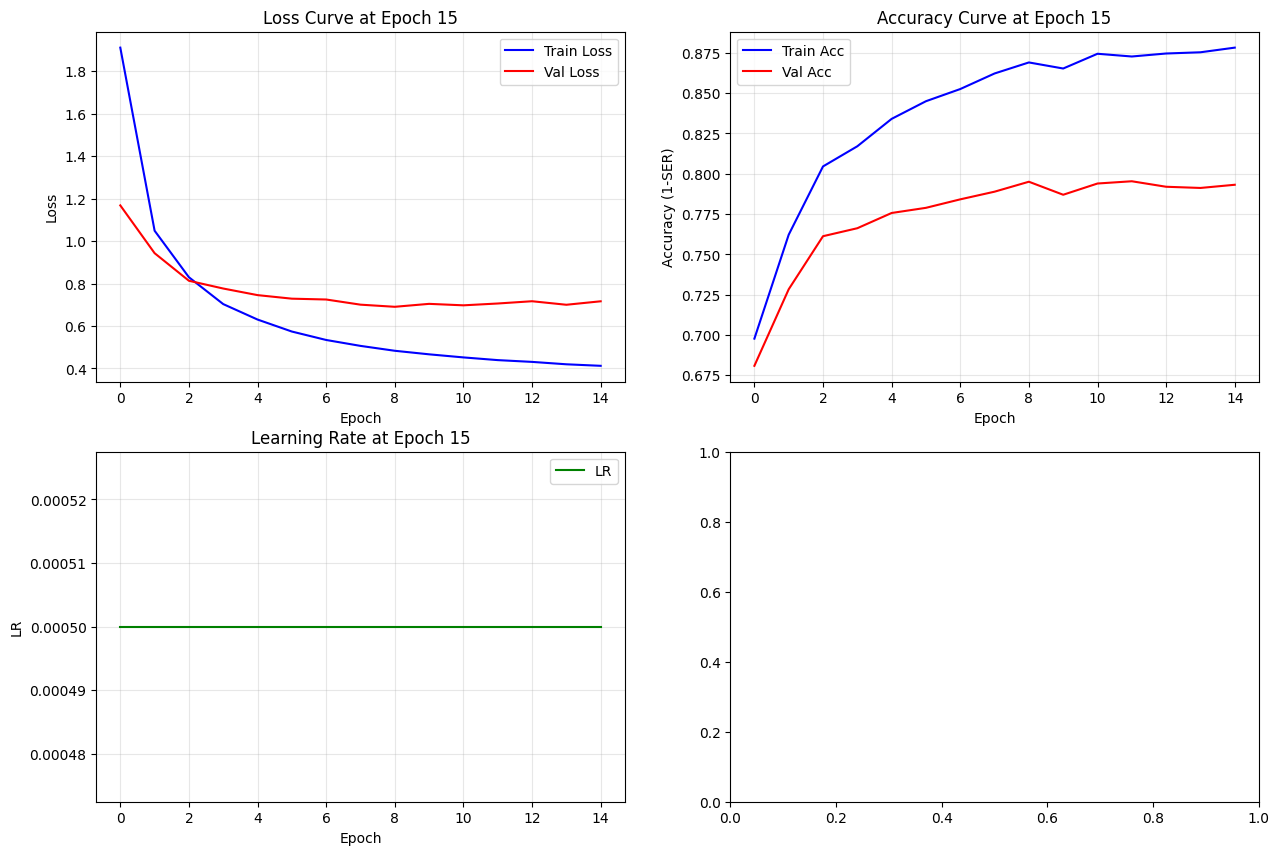

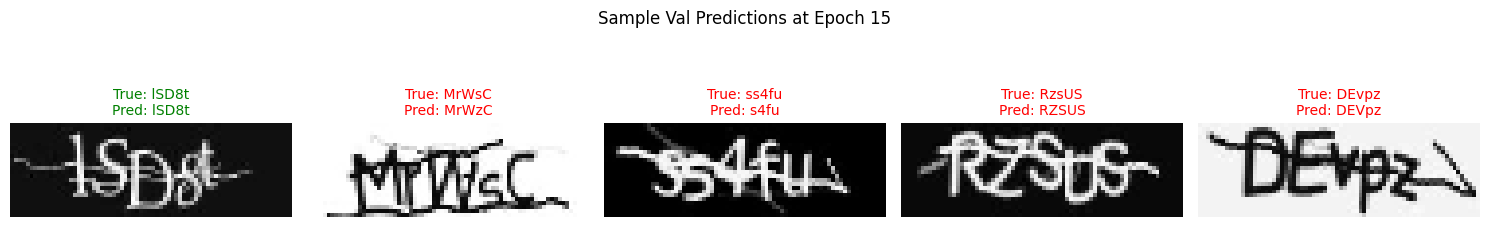

<Figure size 640x480 with 0 Axes>

Epoch 16/50 - Train Loss: 0.4054, Val Loss: 0.6885, Train Acc: 0.8847, Val Acc: 0.7958, LR: 0.000500
Saved best model at epoch 16
Epoch 17/50 - Train Loss: 0.4012, Val Loss: 0.6855, Train Acc: 0.8854, Val Acc: 0.7982, LR: 0.000500
Saved best model at epoch 17
Epoch 18/50 - Train Loss: 0.3924, Val Loss: 0.6977, Train Acc: 0.8888, Val Acc: 0.7988, LR: 0.000500
Epoch 19/50 - Train Loss: 0.3877, Val Loss: 0.6907, Train Acc: 0.8868, Val Acc: 0.7957, LR: 0.000500
Epoch 20/50 - Train Loss: 0.3836, Val Loss: 0.7045, Train Acc: 0.8862, Val Acc: 0.7955, LR: 0.000500


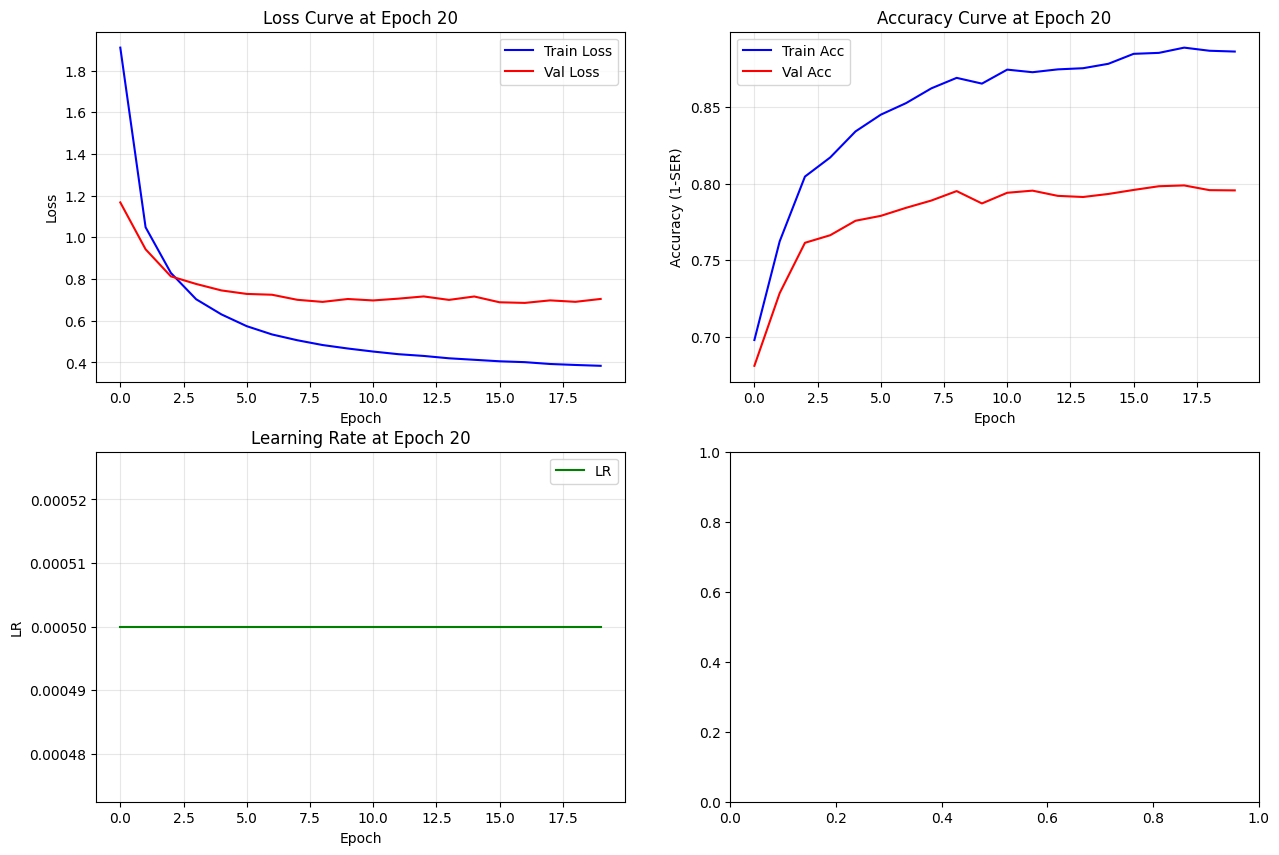

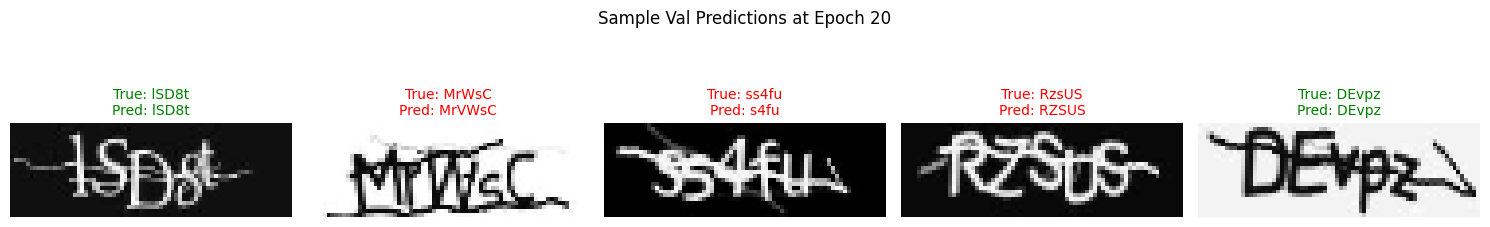

<Figure size 640x480 with 0 Axes>

Epoch 21/50 - Train Loss: 0.3817, Val Loss: 0.7032, Train Acc: 0.8866, Val Acc: 0.7965, LR: 0.000500
Epoch 22/50 - Train Loss: 0.3747, Val Loss: 0.6978, Train Acc: 0.8892, Val Acc: 0.7972, LR: 0.000500
Epoch 23/50 - Train Loss: 0.3727, Val Loss: 0.6948, Train Acc: 0.8912, Val Acc: 0.7973, LR: 0.000500
Epoch 24/50 - Train Loss: 0.3696, Val Loss: 0.6930, Train Acc: 0.8926, Val Acc: 0.7996, LR: 0.000500
Epoch 25/50 - Train Loss: 0.3661, Val Loss: 0.7070, Train Acc: 0.8872, Val Acc: 0.7960, LR: 0.000250


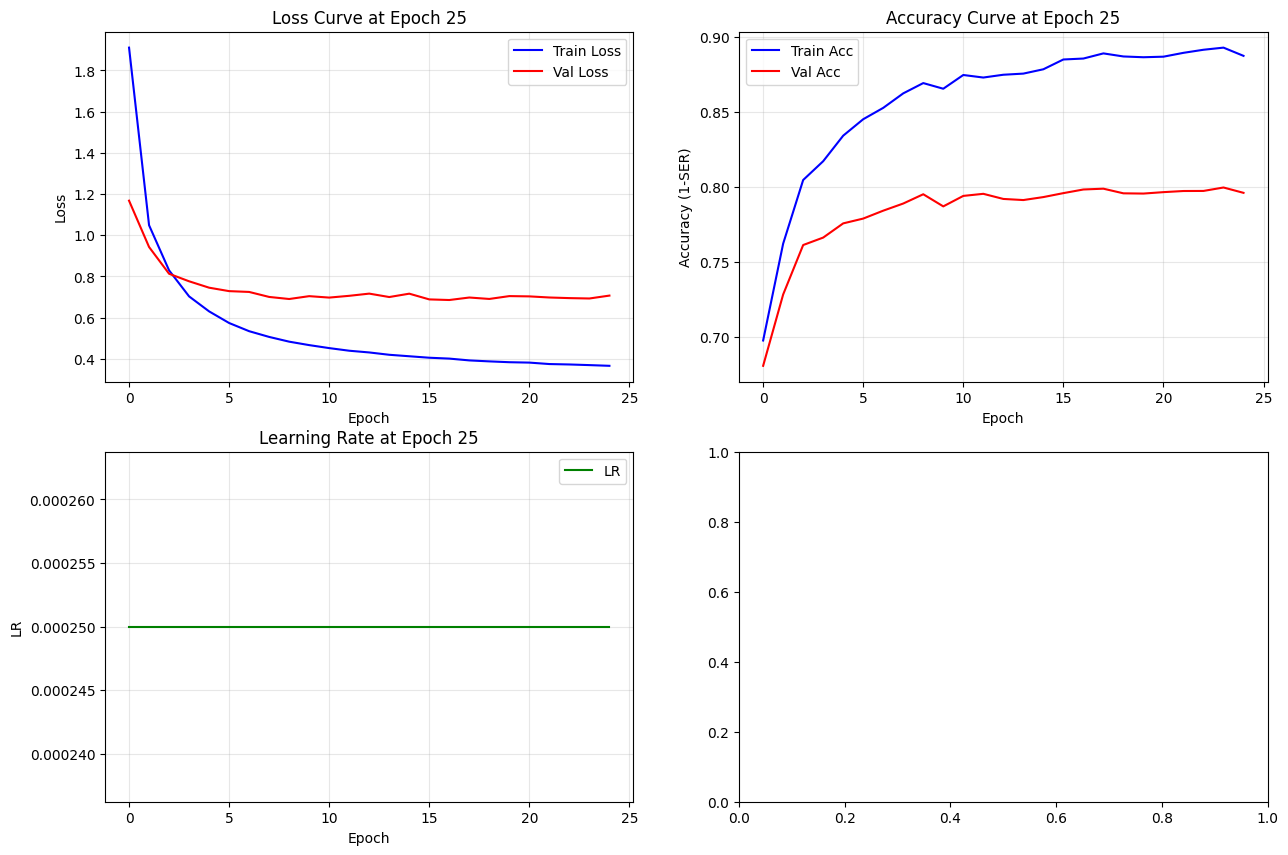

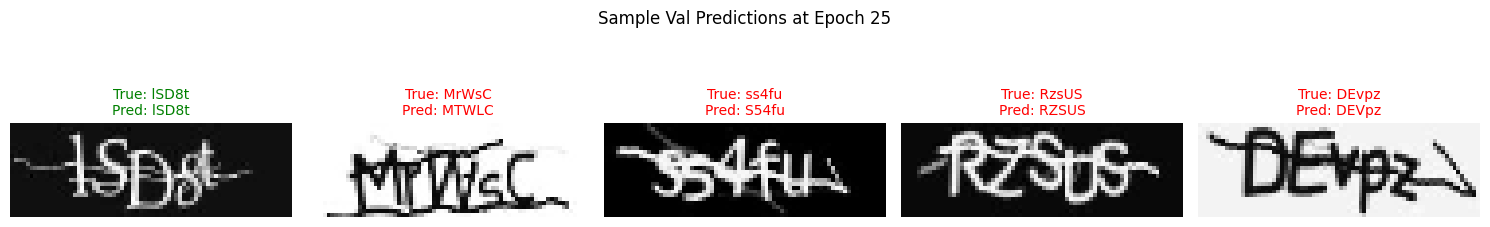

<Figure size 640x480 with 0 Axes>

Epoch 26/50 - Train Loss: 0.2348, Val Loss: 0.6435, Train Acc: 0.9417, Val Acc: 0.8175, LR: 0.000250
Saved best model at epoch 26
Epoch 27/50 - Train Loss: 0.1842, Val Loss: 0.6748, Train Acc: 0.9470, Val Acc: 0.8119, LR: 0.000250
Epoch 28/50 - Train Loss: 0.1877, Val Loss: 0.7110, Train Acc: 0.9456, Val Acc: 0.8094, LR: 0.000250
Epoch 29/50 - Train Loss: 0.1858, Val Loss: 0.7172, Train Acc: 0.9507, Val Acc: 0.8088, LR: 0.000250
Epoch 30/50 - Train Loss: 0.1782, Val Loss: 0.7233, Train Acc: 0.9550, Val Acc: 0.8082, LR: 0.000250


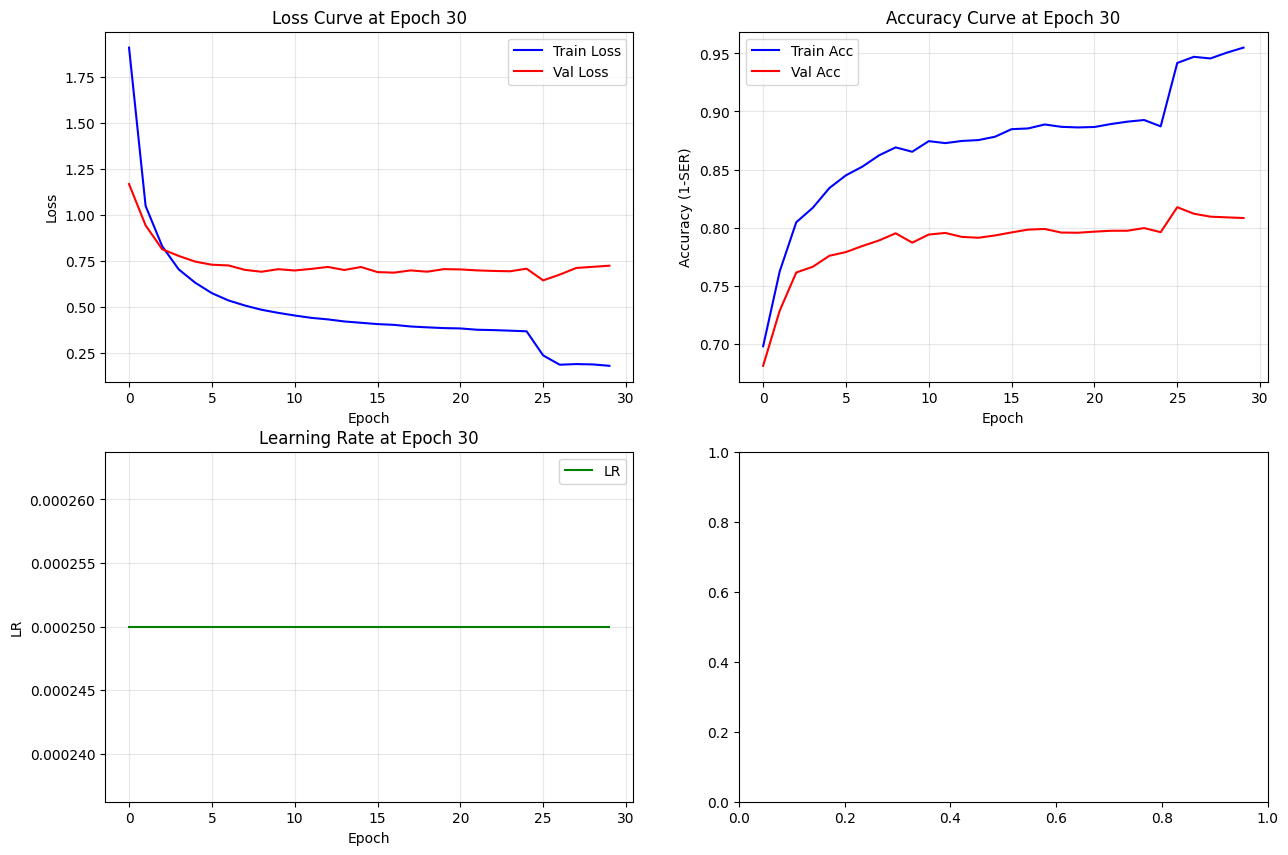

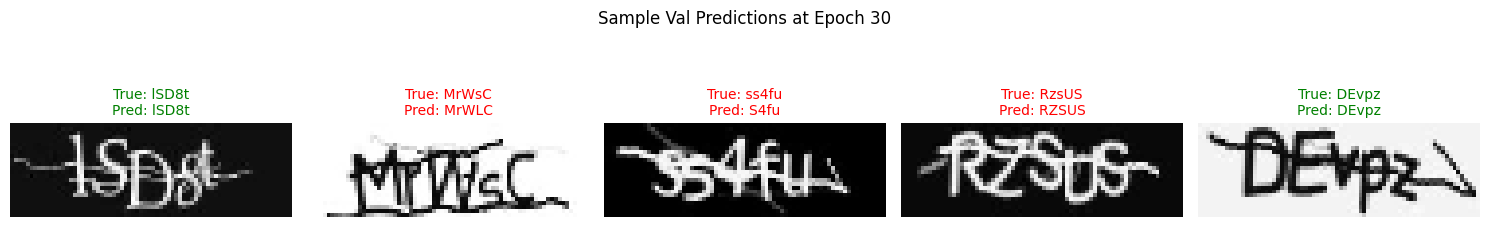

<Figure size 640x480 with 0 Axes>

Epoch 31/50 - Train Loss: 0.1701, Val Loss: 0.7416, Train Acc: 0.9591, Val Acc: 0.8073, LR: 0.000250
Epoch 32/50 - Train Loss: 0.1680, Val Loss: 0.7525, Train Acc: 0.9576, Val Acc: 0.8041, LR: 0.000250
Epoch 33/50 - Train Loss: 0.1620, Val Loss: 0.7616, Train Acc: 0.9622, Val Acc: 0.8049, LR: 0.000250
Epoch 34/50 - Train Loss: 0.1575, Val Loss: 0.7686, Train Acc: 0.9633, Val Acc: 0.8041, LR: 0.000125
Epoch 35/50 - Train Loss: 0.0865, Val Loss: 0.7554, Train Acc: 0.9915, Val Acc: 0.8164, LR: 0.000125


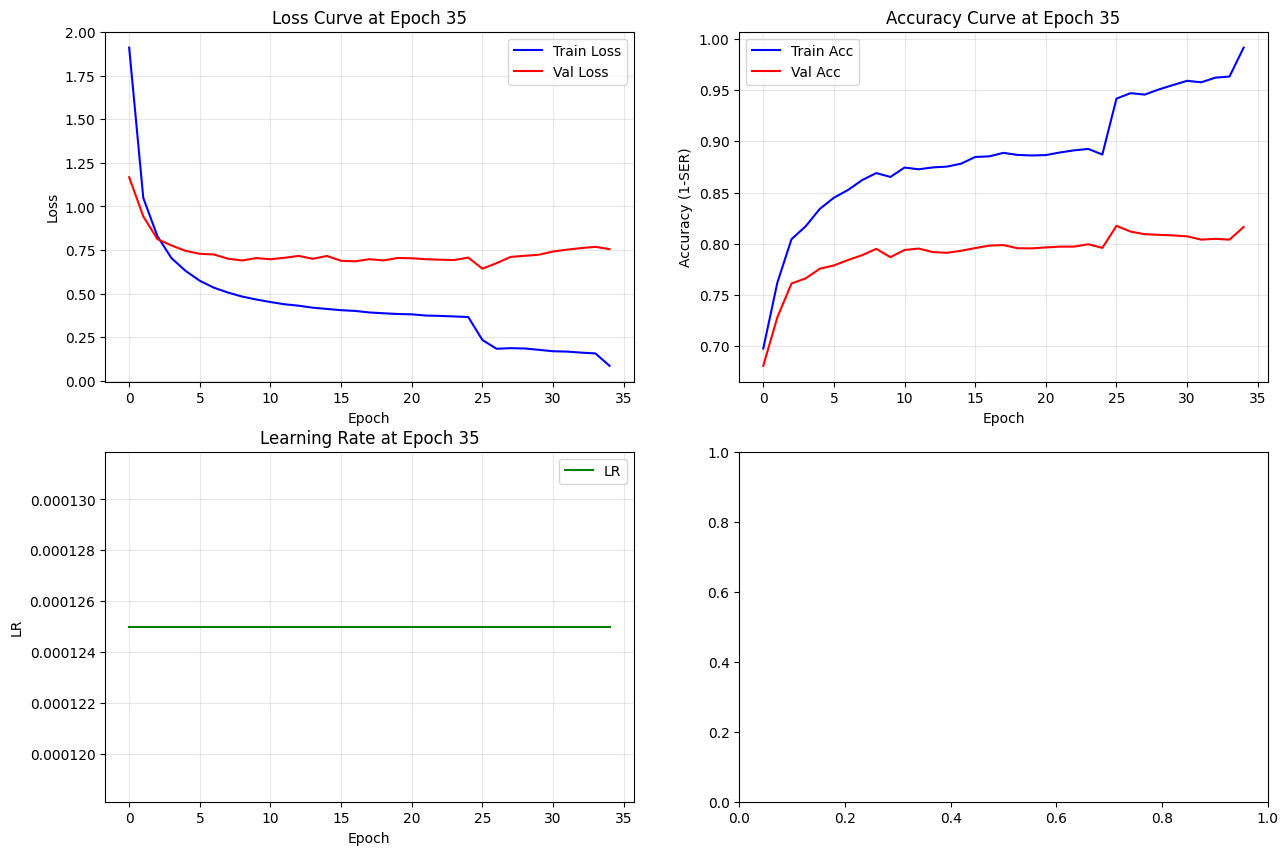

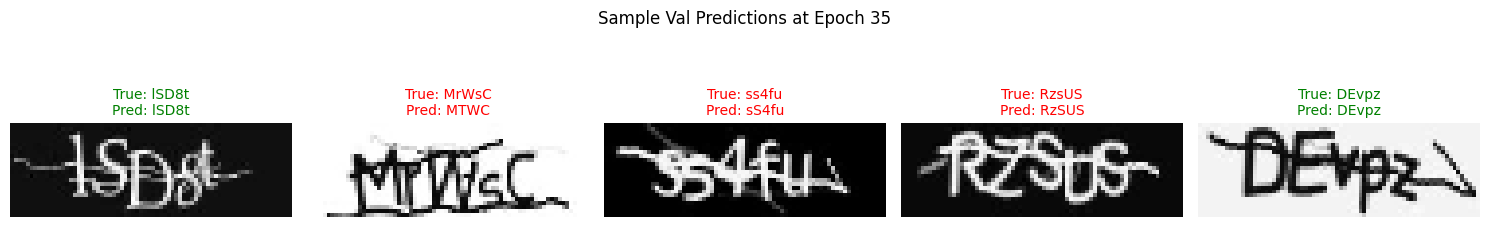

<Figure size 640x480 with 0 Axes>

Epoch 36/50 - Train Loss: 0.0533, Val Loss: 0.7886, Train Acc: 0.9941, Val Acc: 0.8141, LR: 0.000125
Epoch 37/50 - Train Loss: 0.0518, Val Loss: 0.8188, Train Acc: 0.9925, Val Acc: 0.8106, LR: 0.000125
Epoch 38/50 - Train Loss: 0.0606, Val Loss: 0.8305, Train Acc: 0.9904, Val Acc: 0.8070, LR: 0.000125
Epoch 39/50 - Train Loss: 0.0609, Val Loss: 0.8404, Train Acc: 0.9907, Val Acc: 0.8082, LR: 0.000125
Epoch 40/50 - Train Loss: 0.0602, Val Loss: 0.8427, Train Acc: 0.9914, Val Acc: 0.8072, LR: 0.000125


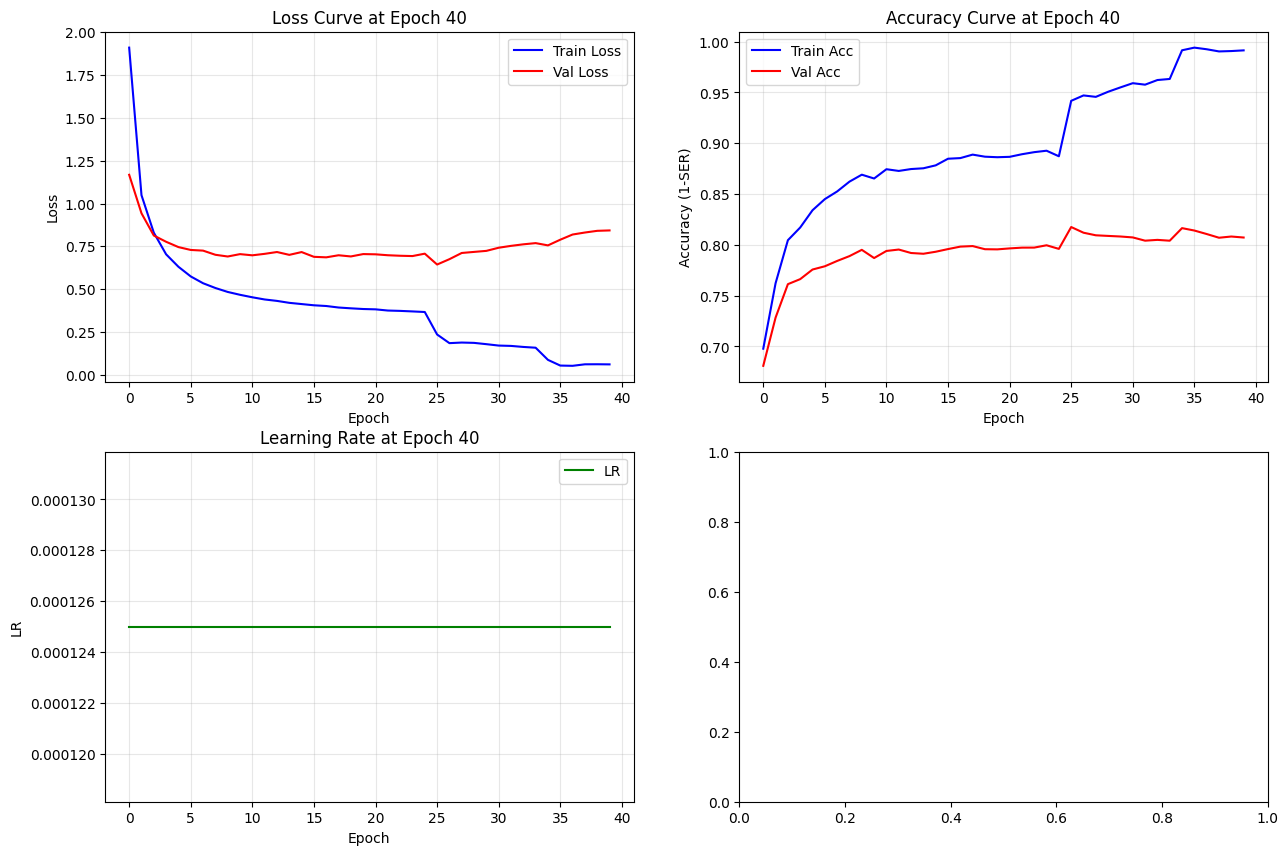

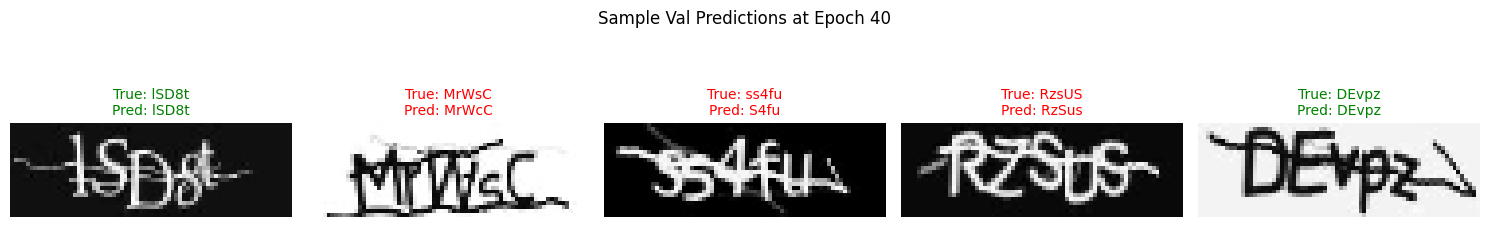

<Figure size 640x480 with 0 Axes>

Epoch 41/50 - Train Loss: 0.0552, Val Loss: 0.8571, Train Acc: 0.9924, Val Acc: 0.8055, LR: 0.000125
Early stopping at epoch 41


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [21]:
patience_counter = 0
for epoch in range(start_epoch, EPOCHS):
    # Train
    model.train()
    train_loss = 0.0
    for imgs, targets, input_lens, target_lens, _ in train_loader:
        imgs = imgs.to(device)
        targets = targets.to(device)
        input_lens = input_lens.to(device)
        target_lens = target_lens.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        log_probs = F.log_softmax(outputs, dim=2)
        loss = criterion(log_probs, targets, input_lens, target_lens)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = compute_ser(model, train_loader, device, is_train=True)
    train_accs.append(train_acc)

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, targets, input_lens, target_lens, _ in val_loader:
            imgs = imgs.to(device)
            targets = targets.to(device)
            input_lens = input_lens.to(device)
            target_lens = target_lens.to(device)
            outputs = model(imgs)
            log_probs = F.log_softmax(outputs, dim=2)
            loss = criterion(log_probs, targets, input_lens, target_lens)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_acc = compute_ser(model, val_loader, device)
    val_accs.append(val_acc)

    scheduler.step(val_loss)
    print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_loss': best_val_loss
    }, CHECKPOINT_FILE)

    # Save metrics
    with open(METRICS_FILE, 'w') as f:
        json.dump({'train_losses': train_losses, 'val_losses': val_losses, 'train_accs': train_accs, 'val_accs': val_accs}, f)

    # Save best & early stopping
    if val_loss < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        patience_counter = 0
        print(f'Saved best model at epoch {epoch+1}')
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break

    # Visualization every VIS_EVERY epochs
    if (epoch + 1) % VIS_EVERY == 0:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        ax1.plot(train_losses, 'b-', label='Train Loss')
        ax1.plot(val_losses, 'r-', label='Val Loss')
        ax1.set_title(f'Loss Curve at Epoch {epoch+1}')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2.plot(train_accs, 'b-', label='Train Acc')
        ax2.plot(val_accs, 'r-', label='Val Acc')
        ax2.set_title(f'Accuracy Curve at Epoch {epoch+1}')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (1-SER)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        lrs = [optimizer.param_groups[0]['lr']] * len(train_losses)
        ax3.plot(lrs, 'g-', label='LR')
        ax3.set_title(f'Learning Rate at Epoch {epoch+1}')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('LR')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

        # Sample predictions
        model.eval()
        sample_preds = []
        sample_trues = []
        sample_imgs = []
        with torch.no_grad():
            for imgs, _, _, _, label_strs in val_loader:
                imgs_batch = imgs.to(device)
                outputs = model(imgs_batch)
                log_probs = F.log_softmax(outputs, dim=2)
                predictions = ctc_greedy_decode(log_probs, BLANK_IDX)
                for j in range(len(imgs)):
                    if len(sample_preds) >= 5:
                        break
                    pred_list = predictions[j].cpu().numpy()
                    pred_str = ''.join([char_list[idx] for idx in pred_list if idx < len(char_list)])
                    orig_str = label_strs[j]
                    sample_preds.append(pred_str)
                    sample_trues.append(orig_str)
                    sample_imgs.append(imgs_batch[j].cpu().squeeze(0).numpy())
                if len(sample_preds) >= 5:
                    break
        fig_sample, axs_sample = plt.subplots(1, 5, figsize=(15, 3))
        for k in range(5):
            match_color = 'green' if sample_trues[k] == sample_preds[k] else 'red'
            title = f"True: {sample_trues[k]}\nPred: {sample_preds[k]}"
            axs_sample[k].imshow(sample_imgs[k], cmap='gray')
            axs_sample[k].set_title(title, fontsize=10, color=match_color)
            axs_sample[k].axis('off')
        plt.suptitle(f'Sample Val Predictions at Epoch {epoch+1}')
        plt.tight_layout()
        plt.show()

        plt.suptitle(f'Training Progress at Epoch {epoch+1}')
        plt.tight_layout()
        plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# TESTING AND EVALUATION

Final Test Accuracy (1-SER): 0.8173
Evaluation Metrics:
Character Error Rate (CER): 0.1033
Word Error Rate (WER): 0.3600
Sequence Error Rate (SER): 0.5750


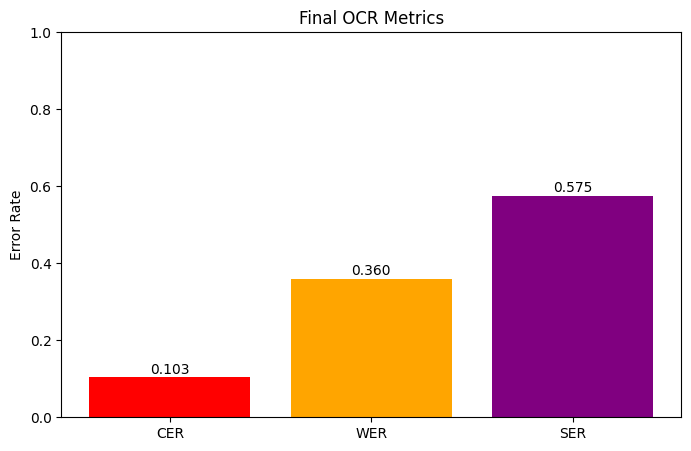

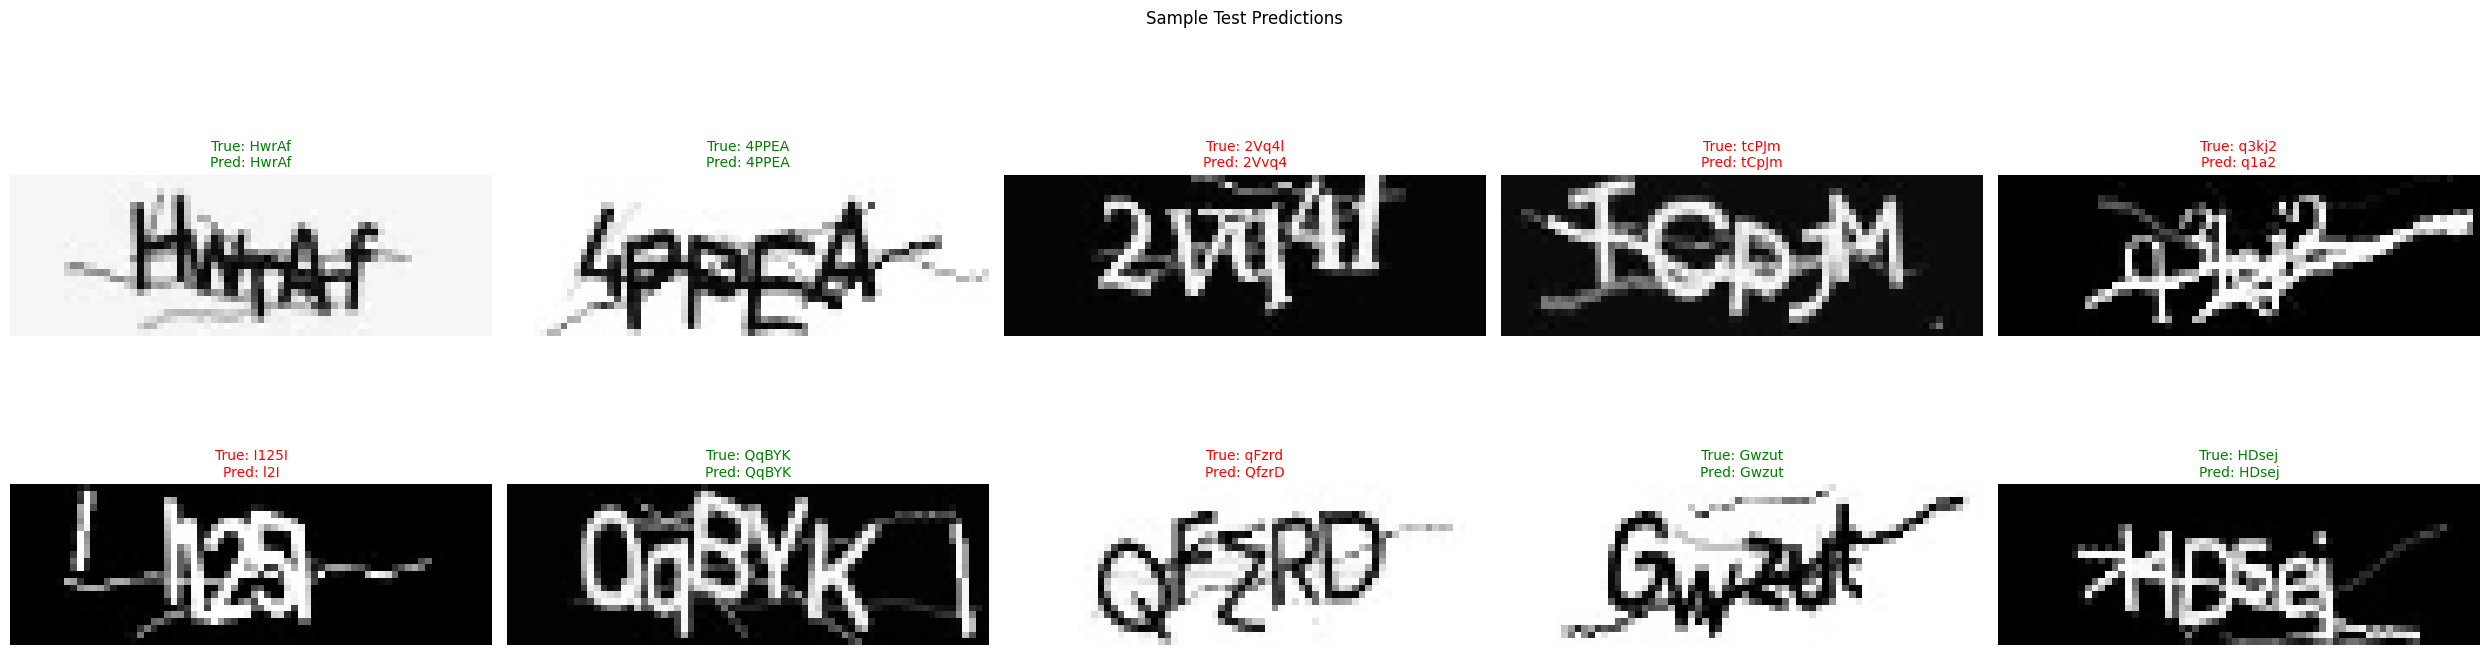

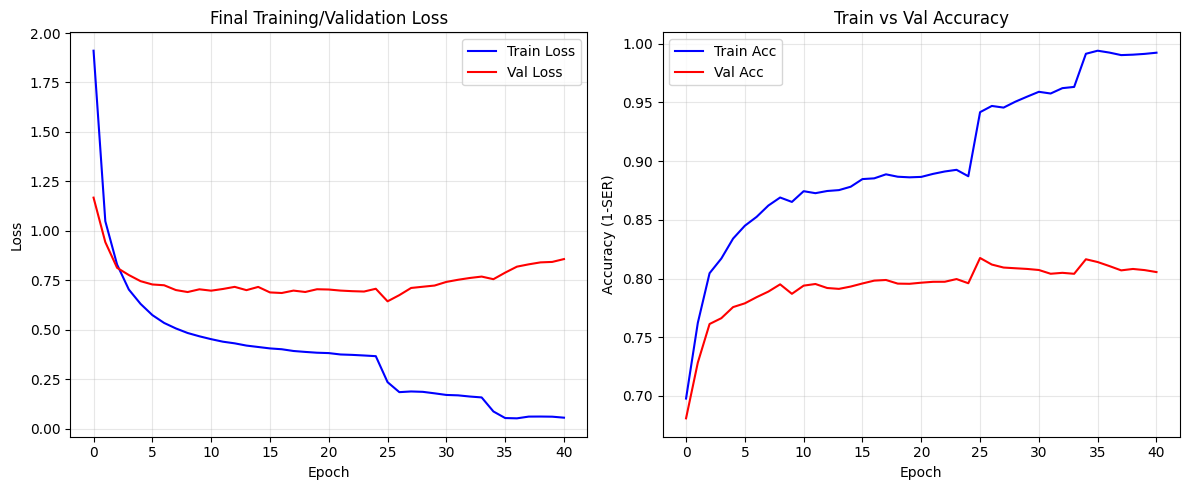

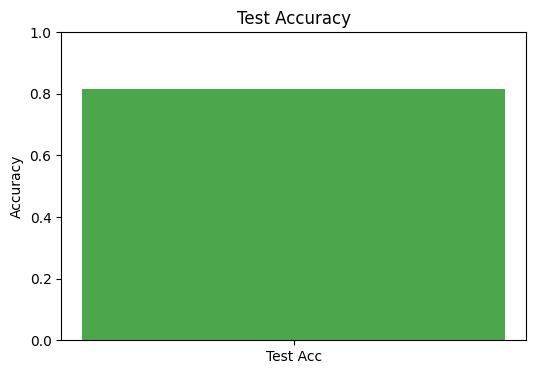

In [22]:
# STEP 8: TESTING AND EVALUATION
# =====================================================
test_acc = compute_ser(model, test_loader, device)
print(f"Final Test Accuracy (1-SER): {test_acc:.4f}")

# Collect test predictions
test_img_list = []
test_orig_txt = []
all_predictions = []
NO_PREDICTS = 200
with torch.no_grad():
    for i, (imgs, _, input_lens, target_lens, label_strs) in enumerate(test_loader):
        current_len = len(test_img_list)
        if current_len >= NO_PREDICTS:
            break
        batch_size = min(len(imgs), NO_PREDICTS - current_len)
        imgs_batch = imgs[:batch_size].to(device)
        label_strs_batch = label_strs[:batch_size]
        outputs = model(imgs_batch)
        log_probs = F.log_softmax(outputs, dim=2)
        predictions = ctc_greedy_decode(log_probs, BLANK_IDX)
        for j in range(batch_size):
            pred_list = predictions[j].cpu().numpy()
            pred_str = ''.join([char_list[idx] for idx in pred_list if idx < len(char_list)])
            orig_str = label_strs_batch[j]
            test_img_list.append(imgs_batch[j].cpu().squeeze(0).numpy())
            test_orig_txt.append(orig_str)
            all_predictions.append(pred_str)

# Evaluation Metrics
def ocr_metrics(predicts, ground_truth):
    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)
    cer, wer, ser = [], [], []
    for pd, gt in zip(predicts, ground_truth):
        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / max(len(pd_cer), len(gt_cer)) if max(len(pd_cer), len(gt_cer)) > 0 else 0)
        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / max(len(pd_wer), len(gt_wer)) if max(len(pd_wer), len(gt_wer)) > 0 else 0)
        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / max(len(pd_ser), len(gt_ser)))
    return (np.mean(cer), np.mean(wer), np.mean(ser))

cer, wer, ser = ocr_metrics(all_predictions, test_orig_txt)
print("Evaluation Metrics:")
print(f"Character Error Rate (CER): {cer:.4f}")
print(f"Word Error Rate (WER): {wer:.4f}")
print(f"Sequence Error Rate (SER): {ser:.4f}")

# Visualization: Metrics bar plot
metrics_names = ['CER', 'WER', 'SER']
metrics_values = [cer, wer, ser]
plt.figure(figsize=(8, 5))
plt.bar(metrics_names, metrics_values, color=['red', 'orange', 'purple'])
plt.title('Final OCR Metrics')
plt.ylabel('Error Rate')
plt.ylim(0, 1)
for i, v in enumerate(metrics_values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.show()

# Visualization: Sample test predictions
num_sample_viz = min(10, len(test_img_list))
rows = 2 if num_sample_viz > 5 else 1
cols = (num_sample_viz + 1) // 2
fig_sample, axs_sample = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axs_sample = axs_sample.flatten() if rows * cols > 1 else [axs_sample]
for k in range(num_sample_viz):
    match_color = 'green' if test_orig_txt[k] == all_predictions[k] else 'red'
    title = f"True: {test_orig_txt[k]}\nPred: {all_predictions[k]}"
    axs_sample[k].imshow(test_img_list[k], cmap='gray')
    axs_sample[k].set_title(title, fontsize=10, color=match_color)
    axs_sample[k].axis('off')
if num_sample_viz < len(axs_sample):
    for j in range(num_sample_viz, len(axs_sample)):
        axs_sample[j].axis('off')
plt.suptitle('Sample Test Predictions')
plt.tight_layout()
plt.show()

# =====================================================
# STEP 9: FINAL VISUALIZATION
# =====================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(train_losses, 'b-', label='Train Loss')
ax1.plot(val_losses, 'r-', label='Val Loss')
ax1.set_title('Final Training/Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_accs, 'b-', label='Train Acc')
ax2.plot(val_accs, 'r-', label='Val Acc')
ax2.set_title('Train vs Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (1-SER)')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.bar(['Test Acc'], [test_acc], color='g', alpha=0.7)
plt.title('Test Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()